In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from scipy.signal import savgol_filter

# Timeseries

In [3]:
maturity   = 'senior_5_13'
method     = 'complete'
city       = 'london'
datafile   = 'FINAL_DATA/'
outfolder  = '../../ProcessedData/' + city + '/timeseries/' + maturity  
infile     = '../../ProcessedData/' + city + '/timeseries/senior_timeseries_5_13.dat'
venues_ts  = {}
lengths    = []

for ind, line in enumerate(open(infile)):
    fields = line.strip().split('\t')
    venue  = fields[0]
    ts     = fields[1:]
    venues_ts[venue] = savgol_filter(np.asarray([float(fff) for fff in ts  ] ), 5, 3) 
    lengths.append(len(ts))
    

city        = 'london'
datafile    = 'FINAL_DATA'
successdata = datafile + '/london_venues_success_measures.csv'
venues      = [line.strip() for line in open(datafile + '/senior_venues_lists.dat')]


success  = pd.read_csv(successdata, sep = '\t', index_col = 0)
success  = success[~success.index.duplicated(keep='first')]   
success  = success[success.index.isin(venues)]



successdata_L = datafile + '/london_venues_success_measures_local_like.csv'
success_L     = pd.read_csv(successdata_L, sep = '\t', index_col = 0)
success_L     = success_L[~success_L.index.duplicated(keep='first')]   
success       = success.join(success_L)

success.index.name = 'venue'

success.head()                                         



def get_success_Qs(segments, success, measure, randomized = False):

    if randomized: 
        np.random.shuffle(success[measure])
        
    labels = ['q' + str(i+1) for i in range(segments)]    
        
    success['quartile'] = pd.qcut(success[measure], segments, labels)
    Q1 = list(success[success['quartile'] == labels[0]].index)
    Q4 = list(success[success['quartile'] == labels[-1]].index)

    
    return Q4, Q1, success

VenuesTop, VenuesBottom, success = get_success_Qs(4, success, 'Llikecount', randomized = False)



rise_venues_top = [line.strip().split('\t')[0] for line in open(datafile + '/senior_5_13/clustering_results/sorted_dist_venues_in_rise.dat') if line.strip().split('\t')[0] in VenuesTop][0:10]
fall_venues_top = [line.strip().split('\t')[0] for line in open(datafile + '/senior_5_13/clustering_results/sorted_dist_venues_in_fall.dat') if line.strip().split('\t')[0] in VenuesTop][0:10]

In [4]:
def getBinnedDistribution(x, y, nbins):

    n, bins   = np.histogram(x, bins=nbins)
    sy, _  = np.histogram(x, bins=nbins, weights=y)
    mean = sy/n


    return _, mean

/home/milan/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[ 120.31585495  337.81623562  948.50183377 2663.15124555]
[1.53522409e-04 1.14182654e-05 5.86946854e-07 2.98636634e-08]


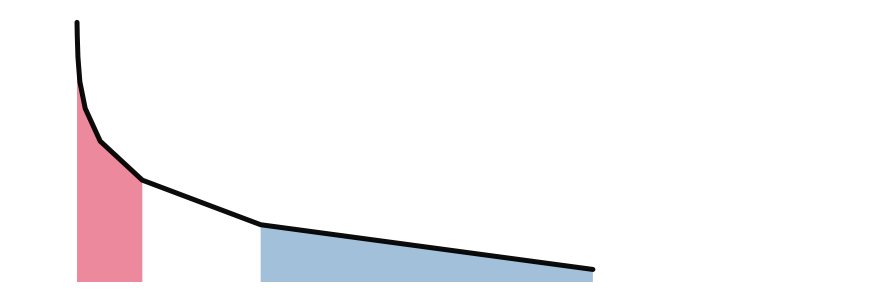

In [5]:
lista = list(success_L.Llikecount)



f, ax = plt.subplots(1,1,figsize = (15,5))
sns.set_style("white")
ax.grid(False)
nbins = 10
counts, bins, bars = ax.hist(lista, normed = True, bins = 10 ** np.linspace(np.log10(min(lista)), np.log10(max(lista)), nbins), log=False,alpha=0.0, cumulative=0)
bins = (bins[1:] + bins[:-1])/2
ax.plot(bins,counts,  '-',  color = 'k', linewidth = 5, markersize = 13, alpha = 0.95)


print bins[-4:]
print counts[-4:]

xx1 = [0.68950049, 1.93594152, 3.43563006]
yy1 = [0.41914026 ,0.17335381, 0.08124256]

xx2 = [    948.50183377, 2663.15124555]
yy2 = [ 5.86946854e-07, 2.98636634e-08]

ax.fill_between(bins[0:7], y1 = 0, y2 = counts[0:7], facecolor='crimson', interpolate=True, alpha = 0.5)
ax.fill_between(xx2, y1 = 0, y2 = yy2, facecolor='steelblue',   interpolate=True, alpha = 0.5)

ax.axis('off')

#ax.set_xscale('log')
ax.set_yscale('log')


In [6]:
import os
outfolder = 'Figures/'
if not os.path.exists(outfolder):
    os.makedirs(outfolder)

In [7]:
f, ax = plt.subplots(1,2, figsize = (15,7))

sss = []
ttt = [] 

for v in rise_venues_top:
    label = str(success.loc[v].checkinsCount) + ' checkins'
    x = venues_ts[v]
    ax[0].plot(x, linewidth = 1.5, alpha = 0.35, color = 'lightgrey')
    ax[0].legend(loc = 'best')
    sss += list(venues_ts[v])
    ttt += list(range(len(x)))
    
    ax[0].axis('off')

bx, by = getBinnedDistribution(ttt, sss, 10)
bx = (bx[1:] + bx[:-1])/2
ax[0].set_ylim([0, 2])
ax[0].plot(bx, by, linewidth = 5, alpha = 0.8, color = 'crimson')





sss = []
ttt = [] 

for v in fall_venues_top:
    label = str(success.loc[v].checkinsCount) + ' checkins'
    x = venues_ts[v]
    ax[1].plot(x, linewidth = 1.5, alpha = 0.35, color = 'lightgrey')
    ax[1].legend(loc = 'best')
    sss += list(venues_ts[v])
    ttt += list(range(len(x)))
    
    ax[1].axis('off')

bx, by = getBinnedDistribution(ttt, sss, 10)
bx = (bx[1:] + bx[:-1])/2
ax[1].set_ylim([0, 2])
ax[1].plot(bx, by, linewidth = 6, alpha = 0.8, color = 'crimson')


plt.tight_layout()

plt.savefig(outfolder + '/1_timeseries.png')
plt.close()

# Clusters

In [8]:
def transform_ts(x, maxTT):

    minx = min(x)  
    x    = [xx - minx for xx in x] 
    maxx = max(x)
    x    = [xx * maxTT / maxx for xx in x]
    
    return x

In [9]:
outfolder  = 'Figures/datafiles/'
files      = [outfolder + f for f in os.listdir(outfolder) if 'clusters_data_all_' in f]

indicies   = [(i,j) for i in range(2) for j in range(3)]
clusters   = [fn.split('_')[3].replace('.dat', '') for fn in files]  

In [10]:
clusters_venues = {}
for cluster in clusters:
    clusters_venues[cluster] = []
    for ind, line in enumerate(open(outfolder + '/sorted_dist/sorted_dist_venues_in_' + cluster + '.dat')):
        if ind == 200: break
        clusters_venues[cluster].append(line.strip().split('\t')[0])

In [11]:
maturity   = 'senior_5_13'
method     = 'complete'
city       = 'london'
datafile   = 'FINAL_DATA/'
outfolder  = '../../ProcessedData/' + city + '/timeseries/' + maturity  
infile     = '../../ProcessedData/' + city + '/timeseries/senior_timeseries_5_13.dat'
venues_ts  = {}
lengths    = []

for ind, line in enumerate(open(infile)):
    fields = line.strip().split('\t')
    venue  = fields[0]
    ts     = fields[1:]
    venues_ts[venue] = savgol_filter(np.asarray([float(fff) for fff in ts  ] ), 5, 3) 
    lengths.append(len(ts))
    
print ind
len(venues_ts)

8378


8379

In [12]:
cluster_ts = {}
lens       = {}

for cluster, venues in clusters_venues.items():
    
    print cluster
    
    cluster_ts[cluster] = []
    
    for v in venues:
        
        y = venues_ts[v]
        x = transform_ts(range(len(y)), 11)   
        
        cluster_ts[cluster].append((x,y))

        


fallandrise
rise
ephemeral
riseandfall
fall
underdogs


fallandrise Fall & Rise
rise Rise
ephemeral Ephemeral
riseandfall Rise & Fall
fall Fall
underdogs Underdogs


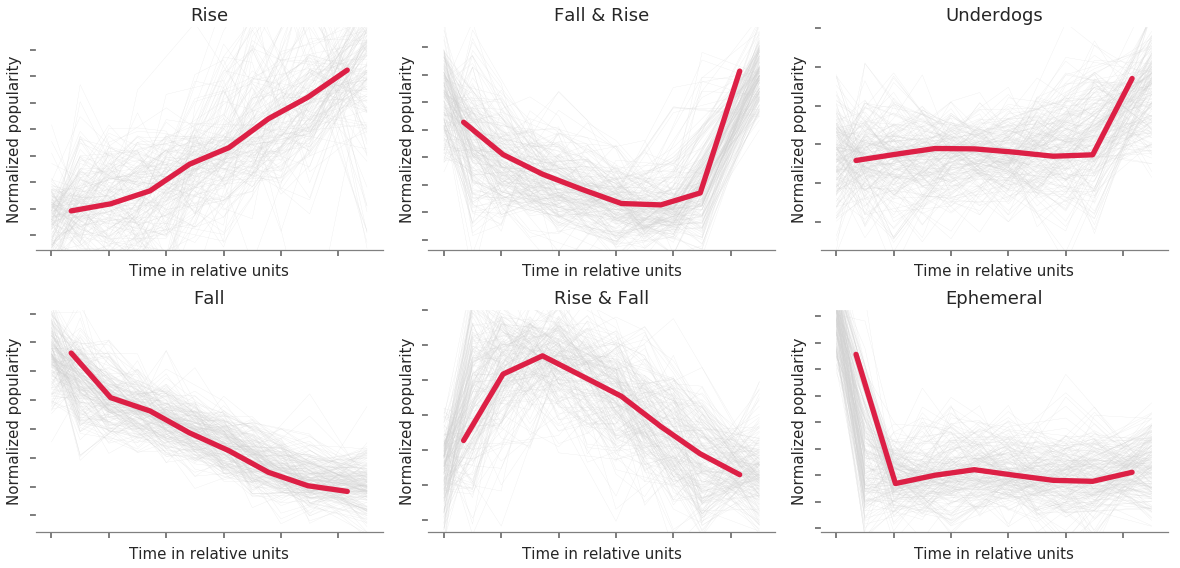

In [16]:
f, ax      = plt.subplots(2, 3, figsize = (16.5,8))
outfolder  = 'Figures/datafiles/'
fig_order  = {'rise' : 0, 'fallandrise' : 1, 'underdogs' : 2, 'fall' : 3, 'riseandfall' : 4, 'ephemeral' : 5 }



for ind, (cluster, venues) in enumerate(cluster_ts.items()):    
    
    if ind > -1:
        
        

        bx      = ax[indicies[fig_order[cluster]]]
    
        for (x, y) in cluster_ts[cluster]:
            bx.plot(x, y, color = 'lightgrey', linewidth = 0.2, alpha = 0.7)
                        

        bbx, bby = zip(*[ tuple([float(fff) for fff in  line.strip().split('\t')])  for line in open(outfolder + 'clusters_data_avg_' + cluster + '.dat')])
        bx.plot(bbx, bby, color = 'crimson', linewidth = 5.3, alpha = 0.95)

        bx.set_ylim([0.5*min(bby),1.2*max(bby)])       
        
        bx.set_xlabel('Time in relative units', fontsize = 15)
        bx.set_ylabel('Normalized popularity',  fontsize = 15)
        
        title = cluster.title()
        if cluster.lower() == 'fallandrise':
            title = 'Fall & Rise'
        elif cluster.lower() == 'riseandfall':
            title = 'Rise & Fall'
        
        print cluster, title
        
        bx.set_title(title, fontsize = 18)

        
        for pos in ['bottom']:
            bx.spines[pos].set_edgecolor('grey')
            
        for pos in ['right', 'top', 'left']:
            bx.spines[pos].set_edgecolor('white')
        
        bx.tick_params(axis='x', length=6, width=2, colors='grey')
        bx.tick_params(axis='y', length=6, width=2, colors='grey')       
        bx.set_xticklabels([])
        bx.set_yticklabels([])
        
        
        #bx.axis('off')
    
  
  
    
    #plt.subplots_adjust(top = 0.95, bottom=0.05, hspace=6.5, wspace=2.4)
#plt.subplots_adjust(hspace=0.5, wspace=0.4)

plt.tight_layout()
plt.savefig('../../../../Dropbox/interns18_venues_success/paper/template-1col/figures/clusters_paper.png')    
plt.savefig('FINAL_FIGURES/clusters_paper.png')

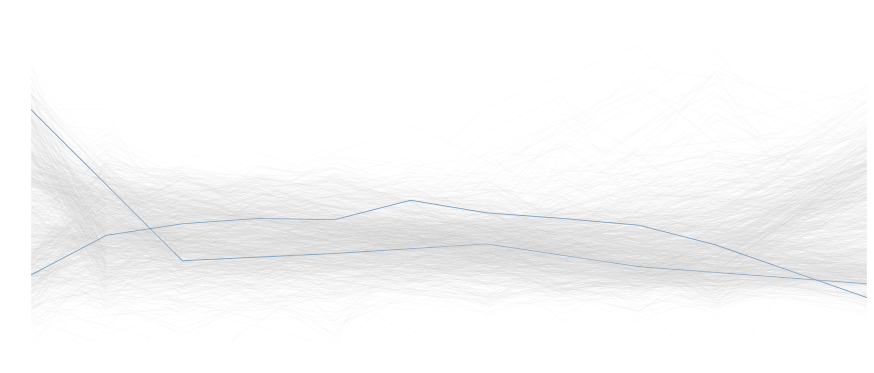

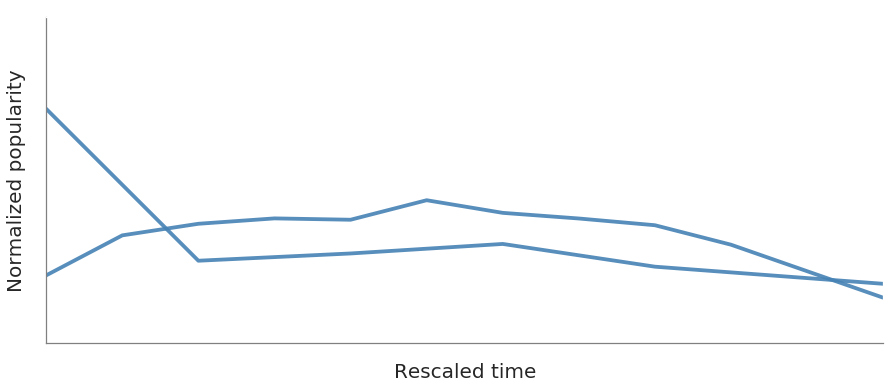

In [51]:
f, ax      = plt.subplots(1, 1, figsize = (15,6))
g, bx      = plt.subplots(1, 1, figsize = (15,6))
outfolder  = 'Figures/datafiles/'


for ind, (cluster, venues) in enumerate(cluster_ts.items()):      
    for (x, y) in cluster_ts[cluster]:      
        p = random.random() 
        if p < 0.0025:
            
            ax.plot(x, y, color = 'steelblue', linewidth = 0.8, alpha = 0.9)
            bx.plot(x, y, color = 'steelblue', linewidth = 3.8, alpha = 0.9)
 
        else:
            ax.plot(x, y, color = 'lightgrey', linewidth = 0.1, alpha = 0.5)

          
            
        ax.set_ylim([0,3])
        bx.set_ylim([0,3])
        ax.set_xlim([0,11])
        bx.set_xlim([0,11])        
            
  

ax.tick_params(axis='x', length=0, width=3, colors='k')
ax.tick_params(axis='y', length=10, width=3, colors='k')
ax.set_xlabel(' ', fontsize = 20)
ax.set_ylabel(' ', fontsize = 20)
ax.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

bx.xaxis.labelpad = 20
bx.yaxis.labelpad = 20





bx.grid('off')
for pos in ['right', 'top']:
    bx.spines[pos].set_edgecolor('white')
    ax.spines[pos].set_edgecolor('white')
    
     
for pos in ['left', 'bottom']:
    bx.spines[pos].set_edgecolor('grey')    
    ax.spines[pos].set_edgecolor('white')    
   

bx.tick_params(axis='x', length=0, width=3, colors='k')
bx.tick_params(axis='y', length=10, width=3, colors='k')
bx.set_xlabel('Rescaled time', fontsize = 20)
bx.set_ylabel('Normalized popularity', fontsize = 20)
bx.get_xaxis().set_ticks([])
bx.axes.get_yaxis().set_ticks([])

bx.xaxis.labelpad = 20
bx.yaxis.labelpad = 20






#plt.tight_layout()
f.savefig('FINAL_FIGURES/timeseriesall.png')
g.savefig('FINAL_FIGURES/timeseries.png')

ephemeral
riseandfall
fall
underdogs
fallandrise
rise


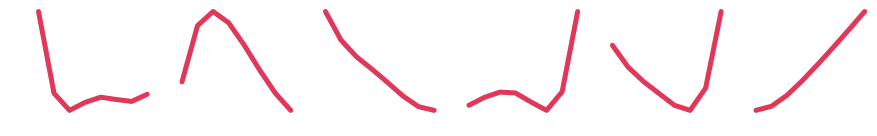

In [53]:
f, ax      = plt.subplots(1, 6, figsize = (15,2))
outfolder  = 'Figures/datafiles/'


#clusters = ['fall', 'rise', 'ephemeral', 'underdogs', 'fallandrise', 'riseandfall']    
clusters = ['ephemeral', 'riseandfall', 'fall', 'underdogs', 'fallandrise','rise']

#random.shuffle(clusters)

for ind, cluster in enumerate(clusters):    
    
    print cluster
    
    bbx, bby = zip(*[ tuple([float(fff) for fff in  line.strip().split('\t')])  for line in open(outfolder + 'clusters_data_avg_' + cluster + '.dat')])

    bby = savgol_filter(np.asarray(bby ), 5, 3)    
    bby = savgol_filter(np.asarray(bby ), 5, 3)    
    bby = savgol_filter(np.asarray(bby ), 5, 3)    
    bby = savgol_filter(np.asarray(bby ), 5, 3)    

    
    
    ax[ind].plot(bbx, bby, color = 'crimson', linewidth = 5, alpha = 0.85)
    ax[ind].axis('off')
    
    
    

# BINARY CLASS

In [54]:
colors_d = { 'WHO'   : '#e41a1c',
             'WHERE' : '#377eb8',
             'WHAT'  : '#984ea3',
             'WHEN'  : '#4daf4a', 
             'ALL'   : 'grey'}


#feat, imp, std = zip(*[line.strip().split('\t') for line in reversed(open('FINAL_DATA/BINARYCLASS_IMPORTANCE.dat').readlines()) ])
feat, imp, std = zip(*[line.strip().split('\t') for line in open('FINAL_DATA/BINARYCLASS_IMPORTANCE.dat') ])
imp    = [float(i) for i in imp]
std    = [float(s) for s in std]
colors = [colors_d[f.split('_')[0]] for f in feat]

colors

['#4daf4a',
 '#e41a1c',
 '#e41a1c',
 '#4daf4a',
 '#984ea3',
 '#377eb8',
 '#e41a1c',
 '#4daf4a',
 '#e41a1c',
 '#377eb8',
 '#377eb8',
 '#e41a1c']

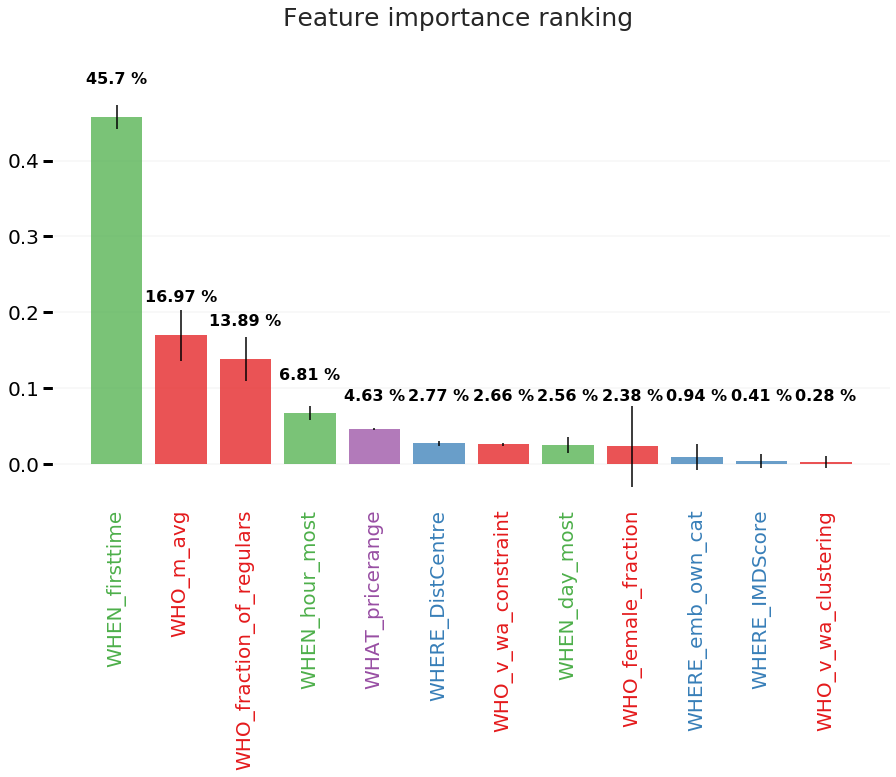

In [55]:
f, ax = plt.subplots(1,1,figsize = (15,11))


ax.yaxis.grid(linewidth = 0.25) 
ax.bar(range(len(imp)), imp, yerr = std, color = colors, alpha = 0.75, align='center')
ax.set_xticks(range(len(imp)))
ax.set_xticklabels(feat, rotation = 90, fontsize = 22, color = colors)

for pos in ['bottom', 'right', 'top', 'left']:
    ax.spines[pos].set_edgecolor('white')

ax.tick_params(axis='x', length=0, width=3, colors='k')
ax.tick_params(axis='y', length=10, width=3, colors='k')

plt.tick_params(axis='both', which='major', labelsize=20)
plt.suptitle('Feature importance ranking', fontsize = 25)

[t.set_color(i) for (i,t) in zip(colors,ax.xaxis.get_ticklabels())]


rects = ax.patches
for rect, label in zip(rects, imp):
    height = rect.get_height()
    label = str(round(100*label, 2)) + ' %'
    
    if height < 0.05:
        height = 0.04
    
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.04 , label,ha='center', weight = 'bold', va='bottom', color = 'k', fontsize = 16)


plt.gcf().subplots_adjust(bottom=0.35)
plt.savefig('FINAL_FIGURES/BINARYSUCCESS_IMPORTANCE.png')

In [56]:
tipus, acc = zip(*[line.strip().split('\t') for line in open('FINAL_DATA/BINARYCLASS_COMPARISON.dat') ])
acc        = [float(a) for a in acc]
colors_c   = [colors_d[f] for f in tipus]

print tipus
print acc

('ALL', 'WHERE', 'WHO', 'WHAT', 'WHEN')
[0.8597962007621953, 0.8609368960427142, 0.8601778582872995, 0.8598033803129219, 0.8590458045553462]


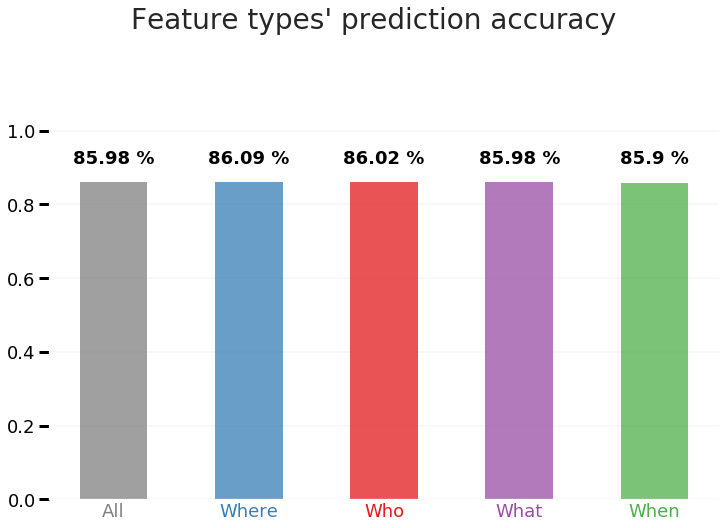

In [57]:
f, ax = plt.subplots(1,1,figsize = (12,8))


ax.yaxis.grid(linewidth = 0.25) 
ax.xaxis.grid(linewidth = 0.0) 

ax.bar([t.title() for t in tipus], acc, color = colors_c, alpha = 0.75, align='center', width = 0.5)
ax.set_xticks(range(len(acc)))
ax.set_ylim([0.0,1.18])

for pos in ['bottom', 'right', 'top', 'left']:
    ax.spines[pos].set_edgecolor('white')

ax.tick_params(axis='x', length=0, width=3, colors='k')
ax.tick_params(axis='y', length=10, width=3, colors='k')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.suptitle('Feature types\' prediction accuracy', fontsize = 28)
#plt.tight_layout()

rects = ax.patches
for rect, label in zip(rects, acc):
    height = rect.get_height()
    label = str(round(100*label, 2)) + ' %'
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.04 , label,ha='center', weight = 'bold', va='bottom', color = 'k', fontsize = 18)



[t.set_color(i) for (i,t) in zip(colors_c,ax.xaxis.get_ticklabels())]
plt.rcParams['xtick.major.pad']=15
plt.savefig('FINAL_FIGURES/BINARYSUCCESS_COMPARISON.png')

# 6 SHAPES CLASSIFICATION

In [17]:
featurenames, importances = zip(*[line.strip().split('\t') for line in open('FINAL_DATA/6CLASS_IMPORTANCE.dat')])

importances = [float(i) for i in importances]
colors_6    = [colors_d[f.split('_')[0]] for f in featurenames]


[f for f in featurenames if 'WHERE' in f]

colors_6

NameError: name 'colors_d' is not defined

In [ ]:
f, ax = plt.subplots(1,1,figsize = (17,11))

sns.set_style("whitegrid")


ax.yaxis.grid(linewidth = 0.25) 
ax.xaxis.grid(linewidth = 0.0) 



ax.bar(range(len(importances)), importances,color = colors_6, alpha = 0.75, align='center', label = 'Who')
ax.bar(range(1), range(1),color = colors_d['WHEN'],   alpha = 0.75, align='center', label = 'When')
ax.bar(range(1), range(1),color = colors_d['WHAT'],  alpha = 0.75, align='center', label = 'What')
ax.bar(range(1), range(1),color = colors_d['WHERE'], alpha = 0.75, align='center', label = 'Where')



ax.set_xticks(range(len(importances)))


#xlabels = ['Birth date', 'Avg buying power', 'Category uniqueness', 'Fraction of females', 'Fraction of regulars', 'IMD score', 'Distance from center', 'Pricerange', 'Network constraint', 'Network clustering']


for pos in ['bottom', 'right', 'top', 'left']:
    ax.spines[pos].set_edgecolor('white')
   
    
ax.tick_params(axis='x', length=0,  width=3, colors='k')
ax.tick_params(axis='y', length=10, width=3, colors='k')
#ax.set_ylim([0.0, 0.25])

plt.tick_params(axis='both', which='major', labelsize = 20)
plt.suptitle('Feature importance ranking',  fontsize  = 25)


[t.set_color(i) for (i,t) in zip(colors_6,ax.xaxis.get_ticklabels())]


rects = ax.patches
for rect, label in zip(rects, importances):
    height = rect.get_height()
    label  = str(round(100*label, 2)) + ' %'
    
    if height < 0.01:
        height = 0.01
    
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.009 , label,ha='center', weight = 'bold', va='bottom', color = 'k', fontsize = 14)

plt.subplots_adjust(top=0.85)   
plt.gcf().subplots_adjust(bottom=0.35)
plt.rcParams['xtick.major.pad']=17.5

xlabels = ['Avg buying power', 'Birth date', 'Category uniqueness','Fraction of females', 'Fraction of regulars', 'Peak hour', 'Distance from center', 'IMD score', 'Peak day',  'Pricerange', 'Network constraint', 'Network clustering']

ax.set_xticklabels(xlabels, rotation = 40, ha = 'right', fontsize = 24)


sns.set_style("whitegrid")

ax.legend(loc = 'best')
patches, labels = ax.get_legend_handles_labels()



plt.savefig('FINAL_FIGURES/6SHAPESSUCCESS_IMPORTANCE.png')



In [18]:
xlabels = ['Avg buying power', 'Birth date', 'Category uniqueness','Fraction of females', 'Fraction of regulars', 'Peak hour', 'Distance from center', 'IMD score', 'Peak day',  'Pricerange', 'Network constraint', 'Network clustering']

In [19]:
values  = []
names   = []
all_val = {}

for line in open('FINAL_DATA/6SHAPES_COMPARISON.dat'):
    tipus, value = line.strip().split('\t')
    value = float(value)
    
    if 'all' in line:
        all_val[tipus] = value
    
    else:
        values.append(value)
        names.append(tipus)
    
    
values  = np.asarray(values).reshape(-1,2)

print values

all_val = np.asarray([all_val.values() for i in range(4)]).reshape(-1,2)

print all_val

[[37.70491803 16.06557377]
 [14.09836066 53.44262295]]
[[88.85245902 88.85245902]
 [88.85245902 88.85245902]]


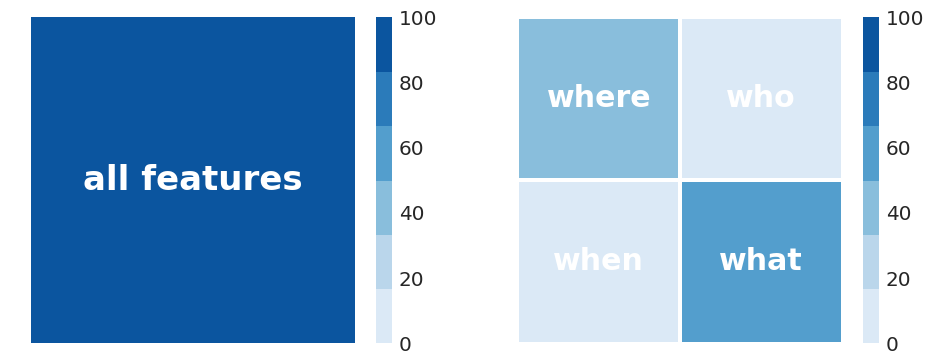

In [20]:
f, ax = plt.subplots(1, 2, figsize = (16,6))
#values = np.asarray( [ [16.23, 47.64], [25.65,82.19] ] )

sns.set(font_scale=2)
 
ax[1] = sns.heatmap(values, cmap=sns.color_palette("Blues"),  ax = ax[1], vmin=0, vmax=100,linewidths=2.5)
ax[0] = sns.heatmap(all_val, cmap=sns.color_palette("Blues"), ax = ax[0], vmin=0, vmax=100,linewidths=0.0)

ax[0].text(1.0,  1.0, 'all features', ha="center", va="center", rotation=0,size=34, weight = 'bold', color = 'white')



ax[1].text(0.5,  0.5, names[0], ha="center", va="center", rotation=0,size=30, weight = 'bold', color = 'white')
ax[1].text(1.5,  0.5, names[1], ha="center", va="center", rotation=0,size=30, weight = 'bold', color = 'white')
ax[1].text(0.5,  1.5, names[2], ha="center", va="center", rotation=0,size=30, weight = 'bold', color = 'white')
ax[1].text(1.5,  1.5, names[3], ha="center", va="center", rotation=0,size=30, weight = 'bold', color = 'white')


for pos in ['bottom', 'right', 'top', 'left']:
    ax[0].spines[pos].set_edgecolor('white')
    ax[1].spines[pos].set_edgecolor('white')


ax[0].tick_params(axis='x', length=0,  width=3, colors='white')
ax[0].tick_params(axis='y', length=10, width=3, colors='white')
ax[1].tick_params(axis='x', length=0,  width=3, colors='white')
ax[1].tick_params(axis='y', length=10, width=3, colors='white')


#plt.suptitle('Relative accuracy of feature types', fontsize = 25)
plt.savefig('FINAL_FIGURES/6SHAPES_FEATGROUPS.png')

